Đánh giá và so sánh hiệu suất của các tổ hợp khác nhau

# IMPORT LIBRARIES & DATA

In [1]:
from GA import solve
from TSP import compute_distance_matrix, visualize
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

In [2]:

file_path = '../data/5_CentralRegion.csv'

In [3]:
locations = pd.read_csv(file_path, header=None).values
locations 

array([['province', 'lat', 'lon'],
       ['Thanh Hóa', '19.9781573', '105.4816107'],
       ['Nghệ An', '19.1976001', '105.0606760'],
       ['Hà Tĩnh', '18.3504832', '105.7623047'],
       ['Quảng Bình', '17.5095990', '106.4004452'],
       ['Quảng Trị', '16.7897806', '106.9797431'],
       ['Thừa Thiên Huế', '16.4639321', '107.5863388'],
       ['Quảng Nam', '15.5761698', '108.0527132'],
       ['Quảng Ngãi', '14.9953739', '108.6917290'],
       ['Bình Định', '14.0779378', '108.9898798'],
       ['Phú Yên', '13.1912633', '109.1273678'],
       ['Khánh Hòa', '12.2980751', '108.9950386'],
       ['Ninh Thuận', '11.6965639', '108.8928476'],
       ['Bình Thuận', '11.1041572', '108.1832931'],
       ['Kon Tum', '14.6995372', '107.9323831'],
       ['Gia Lai', '13.8177445', '108.2004015'],
       ['Đắk Lắk', '12.8292274', '108.2999058'],
       ['Đắk Nông', '12.2818851', '107.7302484'],
       ['Lâm Đồng', '11.6614957', '108.1335279'],
       ['Đà Nẵng', '16.0680000', '108.2120000']], dt

In [4]:
locations_numeric = locations[1:, 1:].astype(float)

distance_matrix = compute_distance_matrix(locations_numeric)

In [5]:
# Danh sách các thuật toán
mutation_algorithms = ['swap', 'scramble', 'inversion', 'insertion']
crossover_algorithms = ['order', 'single_point', 'two_point', 'uniform']
selection_algorithms = ['elitism', 'tournament', 'rank', 'roulette_wheel']

3 tham số mặc định là: 
- population_size = 100
- generations = 200
- mutation_rate = 0.01

# COMBINATION COMPARISON

In [6]:
def plot_fitness(fitness_history):
    generations = len(fitness_history)
    
    # Tính FIR = (fitness đầu tiên - fitness cuối cùng) / số thế hệ
    fir = (fitness_history[0] - fitness_history[-1]) / generations
    
    # Tính AUC (Area Under Curve) dùng sklearn.metrics.auc
    x = np.arange(generations)
    y = fitness_history
    area = auc(x, y)
    
    plt.figure(figsize=(8,5))
    plt.plot(fitness_history, label='Fitness over generations')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Fitness Progression Over Generations')
    
    # Hiển thị FIR và AUC trên biểu đồ
    plt.text(
        0.95, 0.8,
        f'AUC: {area:.2f}',
        ha='right', va='top', transform=plt.gca().transAxes,
        fontsize=18, color='blue',
    )
    
    color = 'green' if fir >= 0.05 else 'red'
    plt.text(
        0.95, 0.7,
        f'FIR: {fir:.4f}',
        ha='right', va='top', transform=plt.gca().transAxes,
        fontsize=18, color=color,
    )
    
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:

def plot_fitness_grid(distance_matrix):
    results = []

    # 1. Chạy tất cả tổ hợp và tính FIR và AUC
    for mutation in mutation_algorithms:
        for crossover in crossover_algorithms:
            for selection in selection_algorithms:
                best_distance, best_route, fitness_history = solve(
                    distance_matrix,
                    population_size=100,
                    generations=200,
                    mutation_rate=0.01,
                    mutation_algorithm=mutation,
                    crossover_algorithm=crossover,
                    selection_algorithm=selection
                )

                fir = (fitness_history[0] - fitness_history[-1]) / len(fitness_history)

                # Tính AUC (Area Under Curve)
                x = np.arange(len(fitness_history))
                y = fitness_history
                area = auc(x, y)

                results.append({
                    'mutation': mutation,
                    'crossover': crossover,
                    'selection': selection,
                    'fitness_history': fitness_history,
                    'fir': fir,
                    'auc': area
                })

    # 2. Sắp xếp theo FIR giảm dần
    results.sort(key=lambda x: x['auc'])

    # 3. Vẽ biểu đồ
    fig, axes = plt.subplots(11, 6, figsize=(18, 33))
    fig.subplots_adjust(hspace=0.7)

    for index, result in enumerate(results):
        row = index // 6
        col = index % 6
        ax = axes[row][col]

        ax.plot(result['fitness_history'])
        ax.set_title(
            f"mut: {result['mutation']}, cross: {result['crossover']}, sel: {result['selection']}",
            fontsize=8
        )
        ax.tick_params(axis='x', labelsize=11)
        ax.tick_params(axis='y', labelsize=11)

        # Vẽ chỉ số FIR và AUC
        ax.text(
            0.95, 0.78,
            f"AUC: {result['auc']:.1f}",
            transform=ax.transAxes,
            ha='right',
            va='bottom',
            fontsize=11,
            color='blue',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6)
        )

        color = 'green' if result['fir'] >= 0.05 else 'red'
        ax.text(
            0.95, 0.68,
            f"FIR: {result['fir']:.3f}",
            transform=ax.transAxes,
            ha='right',
            va='bottom',
            fontsize=11,
            color=color,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6)
        )
        
    # 4. Tắt các ô thừa (66 - 64 = 2)
    for i in range(len(results), 66):
        row = i // 6
        col = i % 6
        fig.delaxes(axes[row][col])

    plt.tight_layout()
    plt.show()


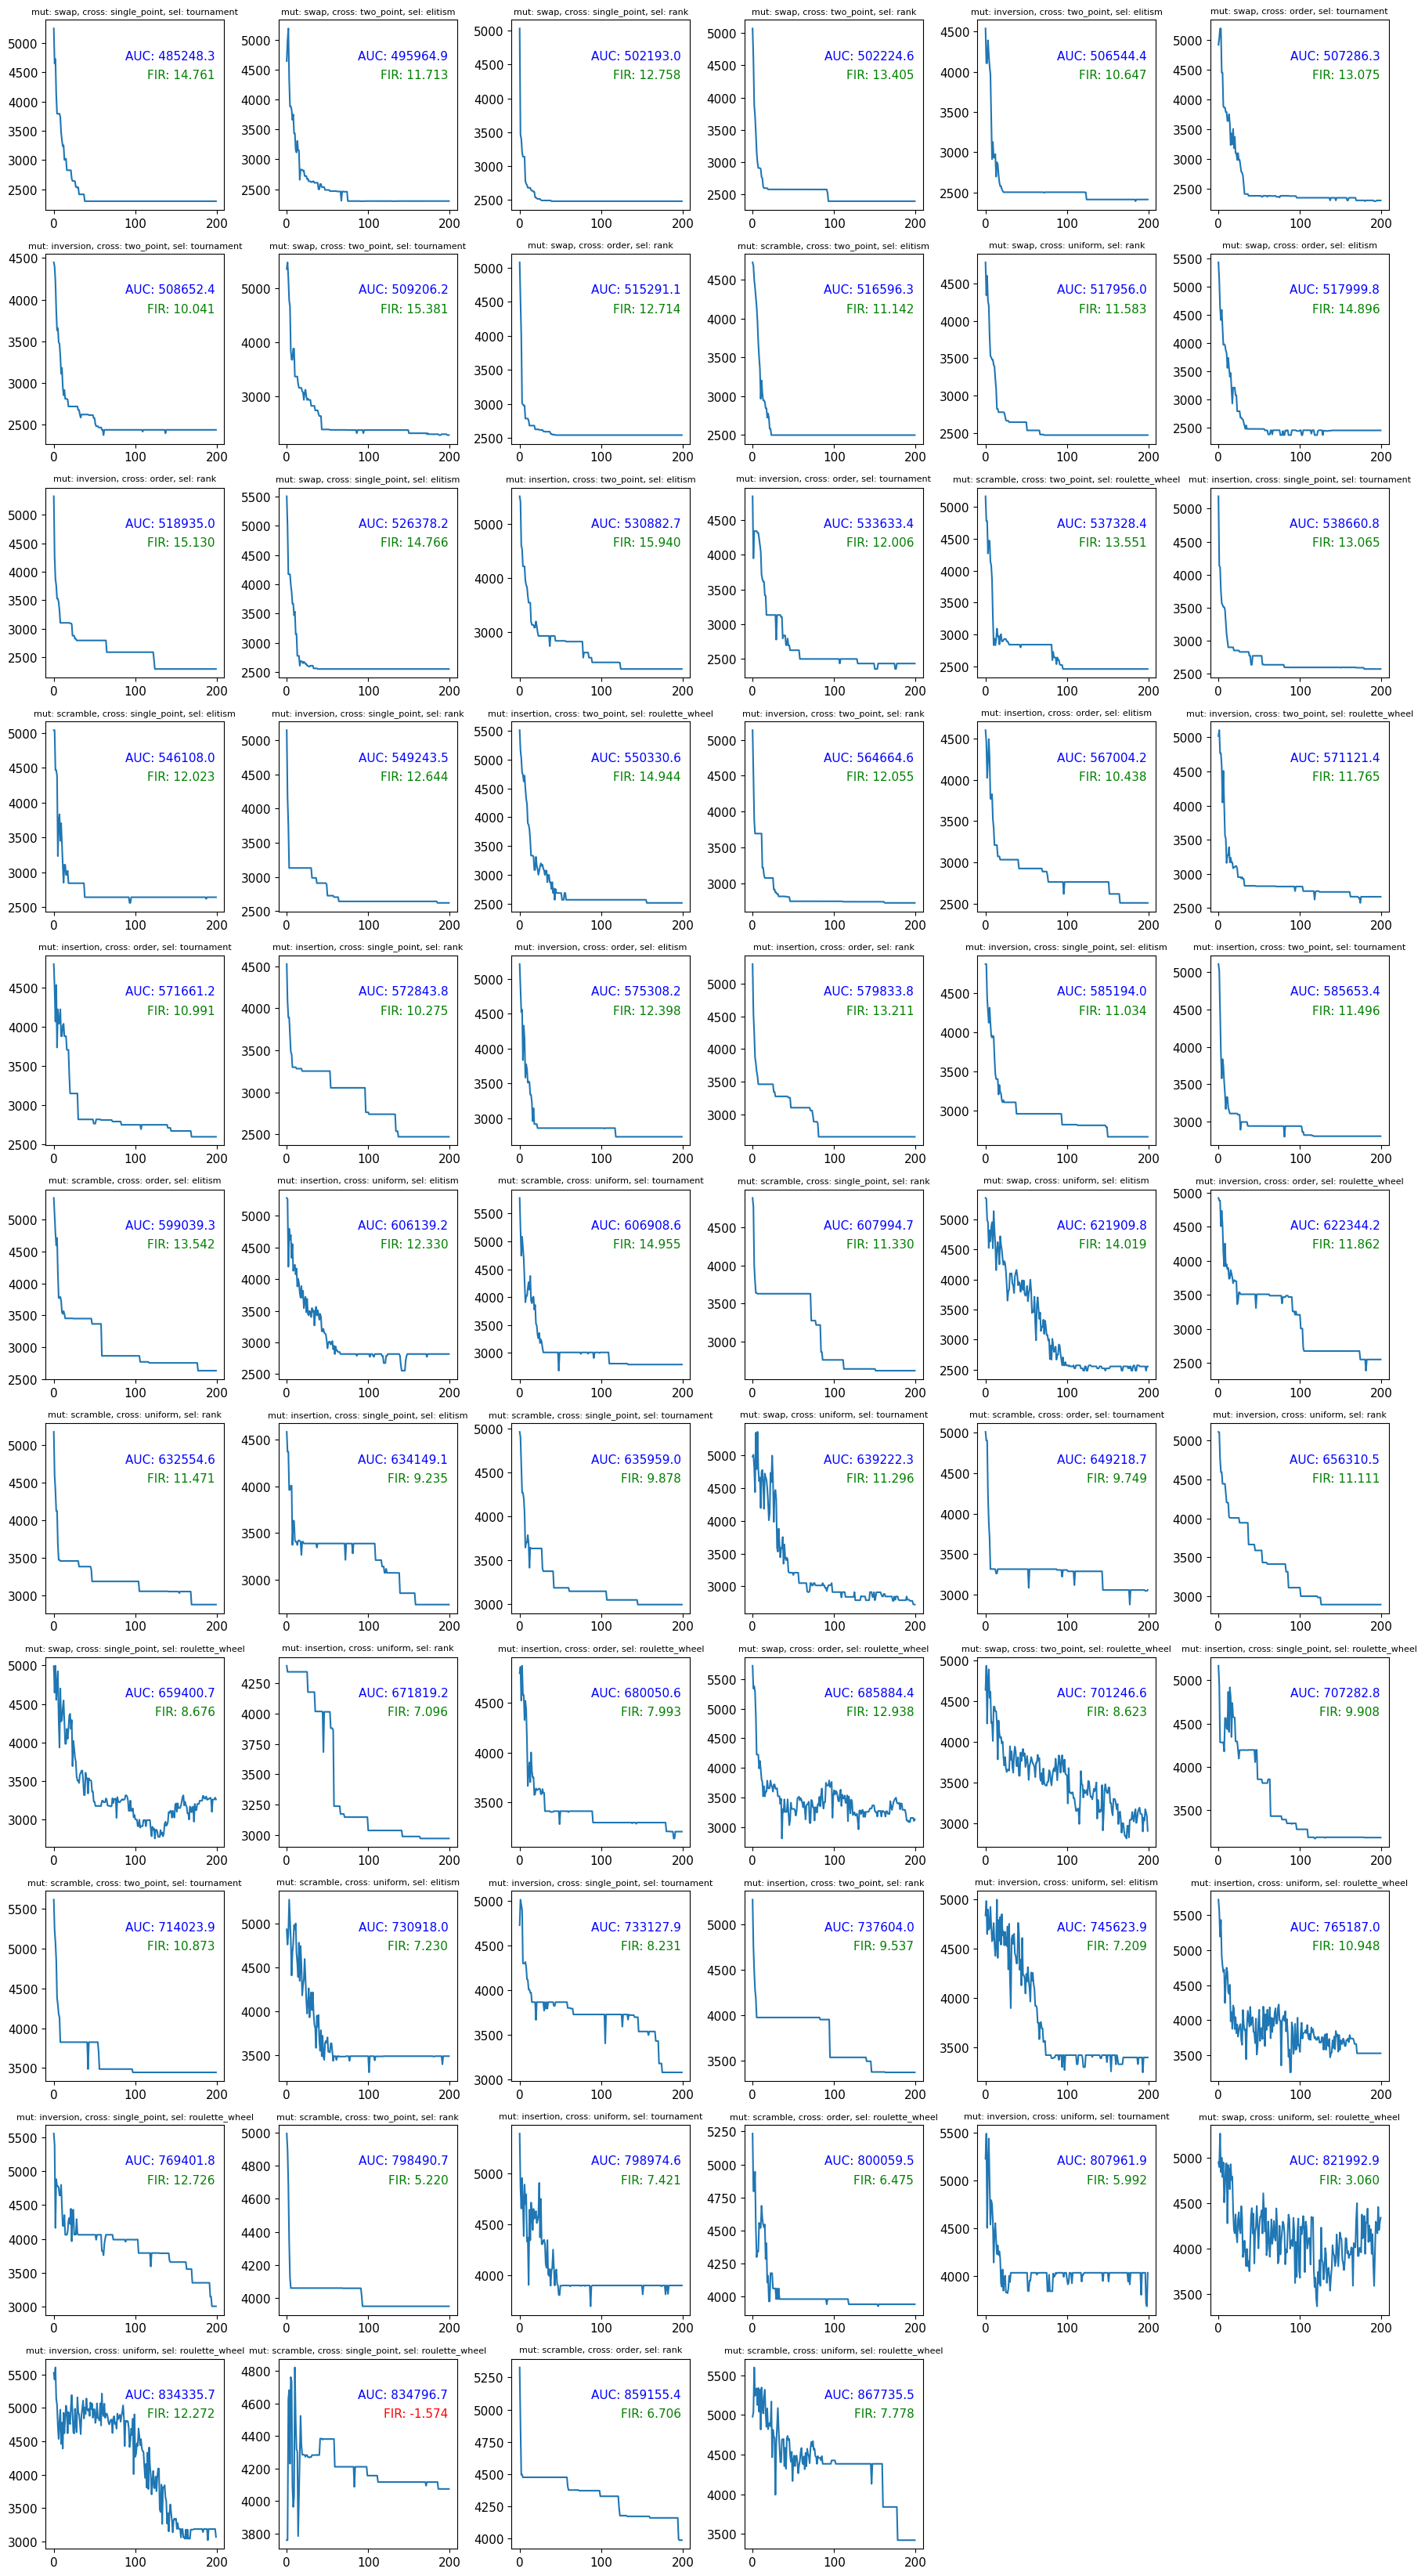

In [8]:
plot_fitness_grid(distance_matrix)

## Tổng quan

- FIR (Fitness Improvement Rate): phản ánh **tốc độ cải thiện độ phù hợp** của mô hình theo thời gian.  
- AUC (Area Under Curve) đại diện cho **chất lượng hội tụ tổng thể** trong suốt quá trình huấn luyện.
- FIR cao + AUC thấp → Hội tụ nhanh và hiệu quả.
- FIR thấp + AUC cao → Hội tụ chậm hoặc kém hiệu quả.

---

## Nhận xét về các tổ hợp mô hình

- Các mô hình **hiệu quả** thường sử dụng:
  - Mutation: `swap`
  - Selection: `rank`
  - Crossover: `two_point`

- Các mô hình **kém hiệu quả** thường sử dụng:
  - Crossover: `uniform`
  - Selection: `roulette_wheel`


# TRƯỜNG HỢP 1
- mutation: swap 
- crossover: order
- selection: elitism


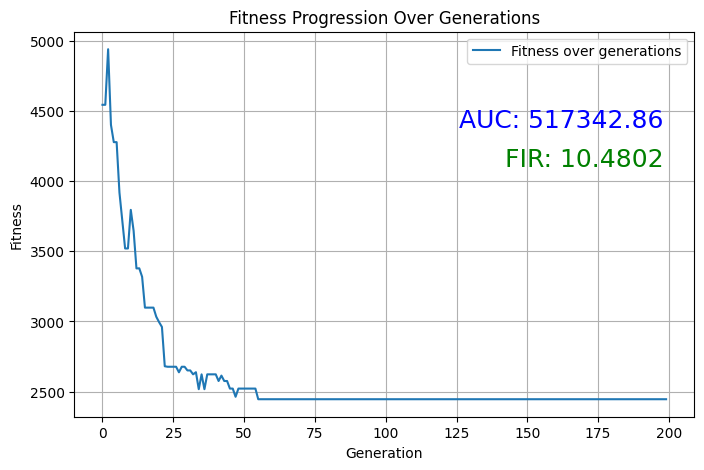

In [9]:
fitness = solve(distance_matrix, generations=200, mutation_rate=0.01, population_size=100, 
                mutation_algorithm='swap', crossover_algorithm='order', selection_algorithm='elitism')[2]
plot_fitness(fitness)


# TRƯỜNG HỢP 2
- mutation: swap
- crossover: uniform
- selection: elitism

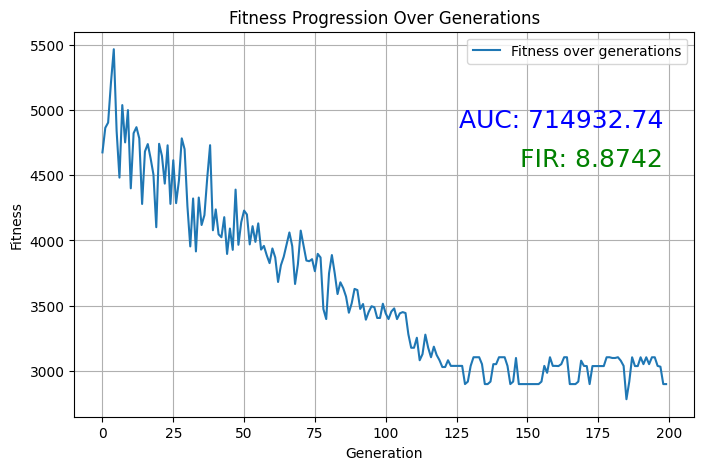

In [10]:
fitness = solve(distance_matrix, generations=200, mutation_rate=0.01, population_size=100, 
                mutation_algorithm='swap', crossover_algorithm='uniform', selection_algorithm='elitism')[2]
plot_fitness(fitness)


# TRƯỜNG HỢP 3
- mutation: inversion
- crossover: uniform
- selection: roulette_wheel

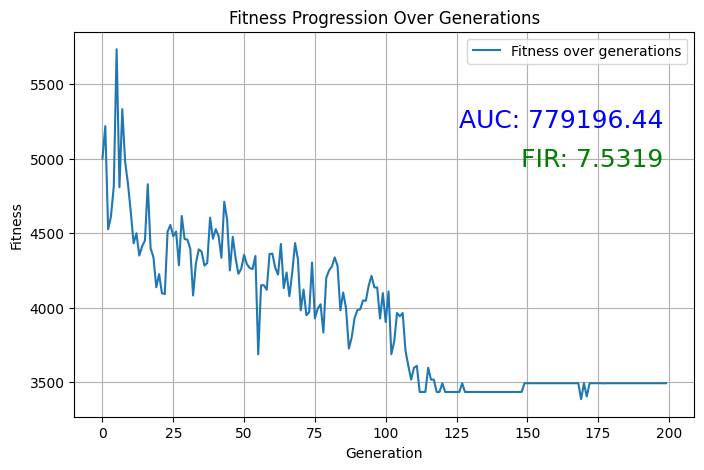

In [11]:
fitness = solve(distance_matrix, generations=200, mutation_rate=0.01, population_size=100, 
                mutation_algorithm='inversion', crossover_algorithm='uniform', selection_algorithm='roulette_wheel')[2]
plot_fitness(fitness)


# TRƯỜNG HỢP 4
- mutation: scramble
- crossover: single_point
- selection: roulette

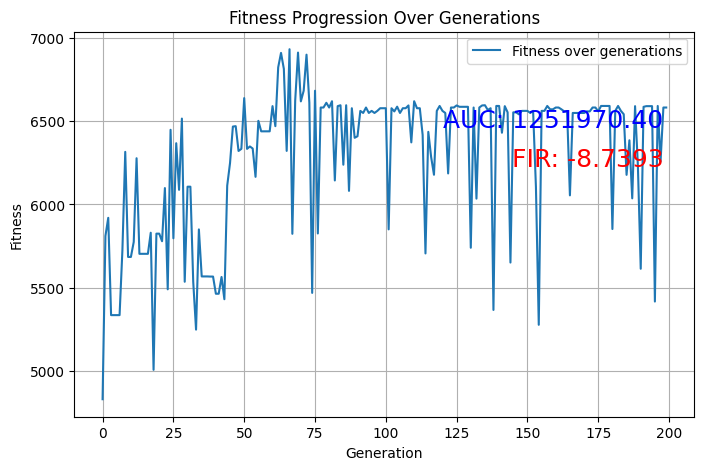

In [13]:
fitness = solve(distance_matrix, generations=200, mutation_rate=0.01, population_size=100, 
                mutation_algorithm='scramble', crossover_algorithm='single_point', selection_algorithm='roulette')[2]
plot_fitness(fitness)


# việc cần làm: 
1. kiểm tra lỗi chính tả và thứ tự các tổ hợp, thỉnh thoảng chị nhầm chỗ crossover và selection nên em check kỹ thứ tự và tên chỗ này nha 
2. restart và cho chạy từ đầu đến cuối ** 1 lần duy nhất **, sau đó viết nhận xét cho 4 Trường hợp, tham khảo bài thiện nah 
